# Using netMHC predictions

In [1]:
import glob, json
import numpy as np
import pandas as pd
from scipy.stats import entropy
import sklearn.decomposition
import sklearn.manifold
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from lib import *
from IPython.display import display, HTML
import weblogolib
from corebio.seq import SeqList, Alphabet

In [ ]:
dfbinders = pd.concat(pd.read_csv(filename, sep=',') for filename in glob.glob('/home/amayer/data/peptidome/netmhc/Malaria-HLA-*.csv'))

In [3]:
totalpeptides = sum(len(seq) for h, seq in fasta_iter(human))
totalpeptides

11370791

In [4]:
counter9 = count_kmers_proteome(malaria, 9)

In [5]:
len(counter9)

3811113

In [6]:
len(dfbinders['Peptide'].unique()), len(np.array(dfbinders['Peptide']))

(140564, 202511)

In [7]:
# 50nM = strong binding
# 500nM = weak binding
dfbinders = dfbinders[dfbinders['nM']<500]
dfbinders.head()

,Unnamed: 0,Pos,Peptide,ID,nM,Rank,Core,H_Avg_Ranks,N_binders
0,3,3,RFVFILSVL,sp_C6KT68_FENR_,149.5,0.6,RFVFILSVL,0.6,1
1,35,35,RFLFVHDKY,sp_C6KT68_FENR_,417.6,1.0,RFLFVHDKY,1.0,1
2,113,113,YYNELDNNP,sp_C6KT68_FENR_,368.1,0.9,YYNELDNNP,0.9,1
3,188,188,NYGYCSGFI,sp_C6KT68_FENR_,55.5,0.4,NYGYCSGFI,0.4,1
4,206,206,YLTGAHGYF,sp_C6KT68_FENR_,51.6,0.4,YLTGAHGYF,0.4,1


In [8]:
seqs = SeqList(list(dfbinders['Peptide']), alphabet=Alphabet(aminoacids))
data = weblogolib.LogoData.from_seqs(seqs)
options = weblogolib.LogoOptions()
options.logo_title = 'HLA-A0101'
f = weblogolib.LogoFormat(data, options)
svg = weblogolib.svg_formatter(data, f)
display(HTML(svg.decode('ascii')))

In [9]:
with open('../data/triplet-human.json', 'r') as f:
    tripletparams = json.load(f)

In [11]:
k = 9
loglikelihood = lambda seq, k: loglikelihood_triplet(seq, **tripletparams, k=k)
phuman = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(human) for i in range(len(seq)-k+1) ])

In [41]:
dfproteomes = pd.read_csv('../data/proteomes.csv', sep=',')
pathogenproteomes = dfproteomes[dfproteomes['type'].isin(['parasite'])]

#dfepitopes = pd.read_csv(datadir+'allhuman-iedb-epitopes.csv', header=1, usecols=(2, 9, 14))
#iedbname = pathogenproteomes['iedbname'].iloc[0]
#dfepitope = dfepitopes[dfepitopes['Parent Organism'].str.contains(iedbname)]
dfepitope = pd.read_csv(datadir+'iedb-Malaria-MHCI-humanhost.csv', header=1, usecols=(2, 9, 14))
dfepitope = dfepitopes.fillna('')
dfepitope['length'] = [len(d) for d in dfepitope['Description']]
epi = list(dfepitope[dfepitope['length']==k]['Description'])
pepitope = np.array([loglikelihood(seq, k) for seq in epi])
#epi = list(dfepitope['Description'])
#pepitope = np.array([loglikelihood(seq[i:i+k], k) for seq in epi for i in range(len(seq)-k+1)])
pepitope = pepitope[~np.isnan(pepitope)]


path = datadir + pathogenproteomes['path'].iloc[0]
ppathogen = np.array([loglikelihood(seq[i:i+k], k) for h, seq in fasta_iter(path) for i in range(len(seq)-k+1) ])
ppathogen = ppathogen[~np.isnan(ppathogen)]

print(len(phuman), len(ppathogen), len(pepitope))

11207814 4130330 64


In [35]:
preds = []
for filename in glob.glob('/home/amayer/data/peptidome/netmhc/Malaria-HLA-*.csv'):
    dfbinders = pd.read_csv(filename, sep=',')
    ppredepitope = np.array([loglikelihood(seq, k) for seq in dfbinders['Peptide'].unique()])
    ppredepitope = ppredepitope[~np.isnan(ppredepitope)]
    if len(ppredepitope) > 20:
        preds.append(ppredepitope)

No handles with labels found to put in legend.


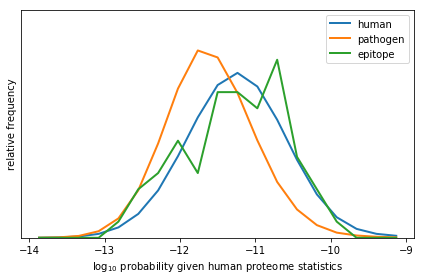

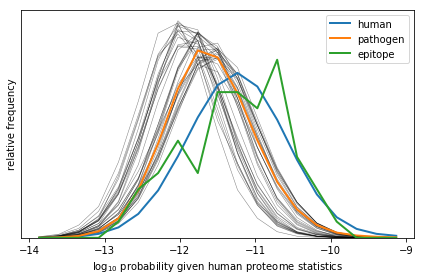

In [47]:
for mhc in [False, True]:
    fig, ax = plt.subplots()
    if mhc:
        plot_histograms(preds,
                        [None]*len(preds),
                        nbins=20, lw=.5, color='k', alpha=.5,
                        xmin=-14, xmax=-9, ax=ax)
    plot_histograms([phuman, ppathogen, pepitope],
                    ['human', 'pathogen', 'epitope'],
                    nbins=20, lw=2,
                    xmin=-14, xmax=-9, ax=ax)
    ax.set_ylabel('relative frequency')
    ax.set_ylim(0.0, 0.22)
    ax.set_yticks([])
    ax.set_xlabel('$\log_{10}$ probability given human proteome statistics')
    fig.tight_layout()
    fig.savefig('plots/likelihoodprofile-Malaria-triplet-k%i%s.png' % (k, '-mhc' if mhc else ''), dpi=300)

In [42]:
dfepi9 = dfepitope[dfepitope['length'] == 9]

In [43]:
len(set(dfepi9['Description'])), len(set(dfepi9['Description']) - set(dfbinders['Peptide'].unique()))

(64, 60)

In [ ]:
with open('peptides.txt', 'w') as f:
    for item in list(dfepi9['Description']):
        f.write("%s\n" % item)

In [ ]:
!netMHC peptides.txt -xls -xlsfile peptides.csv -a HLA-A0101 -p

In [ ]:
pd.read_csv('peptides.csv', sep='\t', skiprows=1)